# Introduction
Mobile carrier Megaline has found out that many of their subscribers use legacy plans.  Megaline wants to develop a model to analyze subscribers' behavior and recommend one of the newer plans: Surf or Ultra.  In this project, we will develop a machine learning model to recommend one of the new plans, based on usage data from subscribers who have already switched to the new plans.

First, we will review the data to gain a general familiarity and to identify any preprocessing requirements.  We will split the data into subsets for model development and testing.  Next, we will build several machine learning models, with the goal achieving the highest possible accuracy.  Our minimum accuracy threshhold will be 0.75.

We will build models using 3 different techniques:  random forest, logistic regression, and naive Bayes.  Finally, we will develop a model that combines the 3 techniques for even higher accuracy.

# Data review and preparation
The data already underwent proprocessing in an earlier project.  In this section, we will review the data to make sure their are no additional preprocessing requirements, and we will split the data into subsets for model development and testing.

In [1]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from statistics import mode
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import warnings

# Not available with the older version of sklearn on Practicum
#from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

warnings.filterwarnings('ignore')

random_state = 12345

try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [2]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Our dataset has 3,214 entries.  There is no missing data, and the data types are appropriate.  The mean and median of the features are fairly close to each other, suggesting limited effect of outliers.  Our target will be <code>is_ultra</code>.  Other columns serve as features in our machine learning models.

## Target-feature correlation

In [4]:
pd.DataFrame(df.corr()['is_ultra']).sort_values(by='is_ultra',ascending=False).\
style.background_gradient(cmap='twilight')

,is_ultra
is_ultra,1.000000
calls,0.207122
minutes,0.206955
messages,0.203830
mb_used,0.198568


Featuers are not closely correlated with the target.

## Training and test datasets
We will split the data into two datasets.  We will use 75% of the data to train and validate our models, and we will hold out the remaining 25% to test our models.

In [5]:
X = df.drop(columns=['is_ultra']).copy()
y = df['is_ultra']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=random_state)

print('Training features shape {} rows, {} columns\n           target shape {} columns\n'.format(
    X_train.shape[0], 
    X_train.shape[1], 
    y_train.shape[0]))
print('Test features shape {} rows, {} columns\n       target shape {} columns\n'.format(
    X_test.shape[0], 
    X_test.shape[1], 
    y_test.shape[0]))

Training features shape 2410 rows, 4 columns
           target shape 2410 columns

Test features shape 804 rows, 4 columns
       target shape 804 columns



We will not create a separate validation sample because we will be using <code>GridSearchCV</code>.  This library performs an exhaustive search over specified parameter values for an estimator.  It avoids overfitting through _k-fold cross-validation_.  With this approach, the training data is split into _k_ smaller sets or folds.  The model is trained using _k-1_ of the folds, and the resulting model is validated on the remaining fold.  This process is repeated for each possible fold, and the performance measure for the model is the average of the measures for each fold.

The advantage cross validation is that it allows us to use a greater portion of our data for training purposes, i.e., a separate validation set is not required. (https://bit.ly/3l7XTdX)  In particular, we will be using 75% of the data for training (and cross-validation) and the remaining 25% for final evaluation.  Had we used a simple arbitrary validation set, a traditional approach would have been to use 60% for training, 20% for validation, and 20% for testing.  The disadvantage of exhaustive search and cross validation is that it is computationally expensive.

## Class distribution and weighting

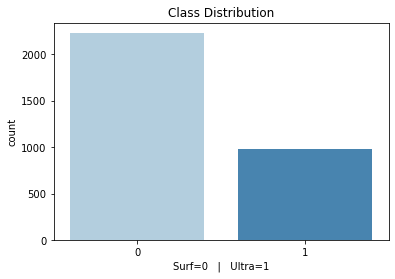

In [6]:
labels ='Surf=0   |   ' + 'Ultra=1'
sns.countplot(x=df['is_ultra'], palette='Blues')
plt.title('Class Distribution')
plt.xlabel(labels);

In [7]:
# Creating our class weights dictionary
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Our class weights:\n{class_weights_dict}")

Our class weights:
{0: 0.7232893157262905, 1: 1.6196236559139785}


Because our classes are unbalanced, we made a class weights dictionary, which can be passed to the model to encourage correct classification by penalizing selection of the majority class and incentivizing selection of the minority class. (https://bit.ly/3nQXNJp)  Some learning models include a hyperparameter for <code>class_weight</code>, allowing passage of our dictionary as well as the use of built-in class weighting strategies.

## Model evaluation criteria
In this section, we present a function that will generate a performance report for each model, and we describe the parts of the report.

### Model evaluation function
<code>evaluate_model()</code> fits the model on the training set and evaluates the model on the test set.  It prints a performance report including accuracy and recall scores, classification report, confusion matrix, and ROC curve.

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit model on training set
    fit_model = model.fit(X_train, y_train)

    # Predict on test, training data
    y_hat_test = fit_model.predict(X_test)
    y_hat_train = fit_model.predict(X_train)

    # Accuracy, precision, and recall scores
    print("\nTraining data")
    print('-' * 13)
    print(f"Accuracy: {accuracy_score(y_train, y_hat_train)}")
    print(f"Precision: {precision_score(y_train, y_hat_train)}")
    print(f"Recall: {recall_score(y_train, y_hat_train)}")
    print("\nTest data")
    print('-' * 9)
    print(f"Accuracy: {accuracy_score(y_test, y_hat_test)}")
    print(f"Precision: {precision_score(y_test, y_hat_test)}")
    print(f"Recall: {recall_score(y_test, y_hat_test)}")
    
    # Classification report
    print("\nClassification Report")
    print('-' * 21)
    print(classification_report(y_test, y_hat_test))
    
    # Confusion matrix
    #labels = sorted(y_test.drop_duplicates().astype(str))
    #ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, display_labels=labels)
    cm = confusion_matrix(y_test, y_hat_test)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC curve on second ax
    #roc_plot = plot_roc_curve(fit_model, X_test, y_test)
    #plt.legend()
    # Threshold line
    #plt.plot([0,1],[0,1],ls=':')
    #plt.title('ROC Curve')
    #plt.show()
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Accuracy, precision, and recall
- __Accuracy__ is the fraction of correct predictions.  It is the main performance metric for this project.  With a class-imbalanced set, it is possible to have a high accuracy (by correctly identifying the majority class), while still failing to identify the minority class. (https://bit.ly/3l8tnRh)
- __Precision__ is the ratio of true positive identifications to total positive identifications.  In this project, it is the ratio of records correctly classified as Ultra to the total records classified as Ultra.  Records classified as Ultra that are actually Surf will drive down our precision with respect to Ultra.
- __Recall__ is the ratio of true positive identifations to total positives.  In this project, it is the ratio of records correctly classified as Ultra to the total number of Ultra records. If we incorrectly identify an Ultra record as Surf, we will our recall with respect to Surf will decrease. (https://bit.ly/2ZnYpwN)

### Classification report
The classification report includes an F1 score, in addition to the scores described above.   

In addition to accuracy, recall, and precision, the classification report includes:
- __F1 score__:  The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. (https://bit.ly/3xlzMNC)
- __Support__:  The number of occurences of the given class in the dataset

### Confusion matrix
A confusion matrix is used to evaluate the quality of the output of a classifier. The diagonal elements (left upper to right lower) represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, the greater the number of correct predictions.  (https://bit.ly/3p4IgoV)

### ROC curve
- A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system.  It is created by plotting the true positive rate (TPR) against the false positive rate (FPR).
- ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis.
- The top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one.
- Curves that are bent toward the top left corner represent better classifiers.  The “steepness” of ROC curves is, since it is ideal to maximize the true positive rate while minimizing the false positive rate.
- A diagonal line from the bottom left to the upper right is called a non-discrimination line and represents a random classifier.
- When given one randomly selected positive instance and one randomly selected negative instance, AUC is the probability that the classifier will be able to tell which one is which. (https://bit.ly/3r7bwxF)

## Conclusion
In this section, we reviewed the dataset, split the data into training and test sets, and we described a function that will be used later to evaluate our machine learning models.

# Random forest

## Model characteristics
- The random forest model builds multiple decision trees from bootstrap samples of the test data, and performs classification by taking a "vote" from these trees.  This process is called bagging, which stands for "bootstrapping and aggregating".  Bagging reduces the variance of a classifier by decreasing the difference in error when we train the model on different datasets. In other words, bagging prevents overfitting. The efficacy of bagging comes from the fact that individual models are quite different due to the different training data and their errors cancel out during voting. Additionally, outliers are likely omitted in some of the training bootstap samples (though random forest can still be sensitive to outliers). (https://bit.ly/3I5kh1B)
- A disadvantage of random forest models is computational complexity.  (This was apparent in this project when using <code>GridSearchCV</code> to select hyperparameters for the <code>RandomForestClassifier</code>, even through our data set is small.)

## Hyperparameter selection
- <code>n_estimators</code> is the number of trees in our forest.
- <code>criterion</code> specifies a function to measure the information gained from a split.
- <code>max_depth</code> can limit the depth of a tree.  Deeper trees can be more accurate for the training data, at the risk of overfitting.
- <code>class_weight</code> can compensate for class imbalance.

In [9]:
params = {'n_estimators': range(100, 1100, 100), 
          'criterion': ['gini'], 
          'max_depth': range(10, 21), 
          'min_samples_leaf': range(2, 11),
          'class_weight': ['balanced', 'balanced_subsample', None]
         }

scoring='f1'

params = {'class_weight': ['balanced'],
          'criterion': ['gini'],
          'max_depth': [11],
          'min_samples_leaf': [9],
          'n_estimators': range(10, 100, 10)
         }

# Best parameters
params = {'class_weight': ['balanced'],
          'criterion': ['gini'],
          'max_depth': [11],
          'min_samples_leaf': [9],
          'n_estimators': [90]
         }

In [10]:
forest = RandomForestClassifier(random_state=random_state)
clf = GridSearchCV(estimator=forest, param_grid=params, scoring=scoring, cv=10)
clf.fit(X_train, y_train)
best_params = clf.best_params_
best_params

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 9,
 'n_estimators': 90}

In [11]:
best_forest = RandomForestClassifier(**best_params, random_state=random_state)
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 90,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

## Model evaluation


Training data
-------------
Accuracy: 0.8522821576763485
Precision: 0.7694444444444445
Recall: 0.7446236559139785

Test data
---------
Accuracy: 0.7786069651741293
Precision: 0.6492890995260664
Recall: 0.5684647302904564

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       563
           1       0.65      0.57      0.61       241

    accuracy                           0.78       804
   macro avg       0.74      0.72      0.73       804
weighted avg       0.77      0.78      0.77       804



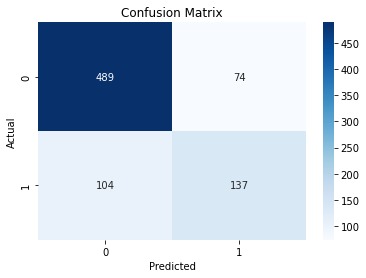

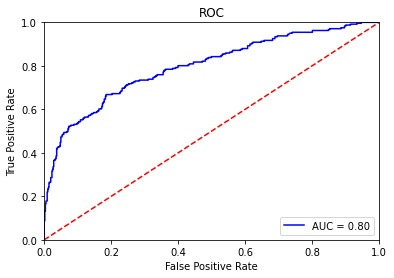

In [12]:
evaluate_model(best_forest, X_train, y_train, X_test, y_test)

## Feature importance

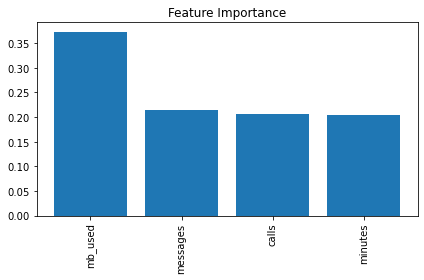

In [13]:
importances = best_forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

## Conclusion
In this section, we performed a grid search to identify a set of hyperparameters for the random forest model.  We used the f1 scoring system for <code>GridSearchCV</code> to incorporate both precision and recall into the model.  Previous iterations showed that we could have achieved a slightly higher accuracy with other scoring systems, but f1 yielded a higher AUC, suggesting a better model overall.  Our selected hyperparameters achieved an accuracy of 78% on the test data.

# Logistic regression

## Model characteristics
Logistic regression is a statistical technique to evaluate the relationship between various predictor variables (either categorical or continuous) and an outcome which is binary (dichotomous).  (https://bit.ly/3xrQRWu)

Advantages of logsistic regression:
- Less prone to overfitting than random forest
- Fast

Disadvantages of logistic regression include:
- Cannot handle non-linear problems
- Cannot to capture complex relationships
- Requires moderate or no multicollinearity between independent variables (https://bit.ly/3DVvGyf)

## Hyperparameter selection
- <code>max_iter</code> is the number of iterations.
- <code>solver</code> is the algorithm to use for optimization.
- <code>class_weight</code> is to troubleshoot unbalanced data sampling.

In [14]:
params = {'penalty' : ['l2'],
          'tol' : [10**i for i in range(-10, 0)],
          'C' : [0.001, 0.01, 0.1],
          'fit_intercept' : [True],
          'max_iter' : range(10, 210, 10),
          'class_weight': [class_weights_dict, 'balanced', None]
         }

scoring = 'f1'

params = {'penalty' : ['l2'],
          'tol' : [10**i for i in range(-12, 0)],
          'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1],
          'fit_intercept' : [True],
          'max_iter' : range(10, 210, 10),
          'class_weight': [class_weights_dict, 'balanced', None]
         }

scoring = 'f1_weighted'

# Best parameters

params = {'C': [0.0001],
          'class_weight': [None],
          'fit_intercept': [True],
          'max_iter': [90],
          'penalty': ['l2'],
          'tol': [1e-12]}

In [15]:
logistic = LogisticRegression(random_state=random_state)
clf = GridSearchCV(estimator=logistic, param_grid=params, scoring=scoring, cv=10)
clf.fit(X_train, y_train)
best_params = clf.best_params_
best_params

{'C': 0.0001,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 90,
 'penalty': 'l2',
 'tol': 1e-12}

In [16]:
best_logistic = LogisticRegression(**best_params, random_state=random_state)
best_logistic.get_params()

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 90,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12345,
 'solver': 'lbfgs',
 'tol': 1e-12,
 'verbose': 0,
 'warm_start': False}

## Model evaluation


Training data
-------------
Accuracy: 0.7120331950207469
Precision: 0.5694444444444444
Recall: 0.27553763440860213

Test data
---------
Accuracy: 0.722636815920398
Precision: 0.5882352941176471
Recall: 0.24896265560165975

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       563
           1       0.59      0.25      0.35       241

    accuracy                           0.72       804
   macro avg       0.67      0.59      0.59       804
weighted avg       0.70      0.72      0.68       804



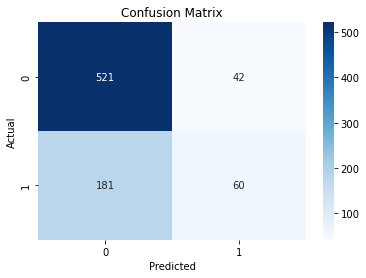

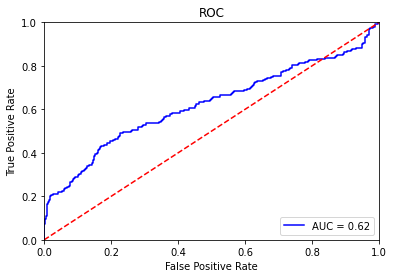

In [17]:
evaluate_model(best_logistic, X_train, y_train, X_test, y_test)

## Conclusion
Logistic regression was the worst performer.  In an earlier iteration, when <code>GridSearchCV</code> scored on accuracy (<code>scoring='accuracy'</code>), logistic regression achieved an accuracy of 70%, but it failed to identify Ultra subscribers (recall score just 6%).  In the current iteration, with <code>GridSearchCV</code> scored on f1-weighted, logistic regression did slightly better at in identifying Ultra (recall score of 25%), but while improving accuracy to 72%.

One plausible explanation for the failure of logistic regression is multicollinearity:  two of the features (<code>calls</code> and <code>minutes</code>) are very closely correlated.  However, even when one of these features was removed, logistic regression still performed poorly.

In [18]:
X_test.corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982135,0.237576,0.300793
minutes,0.982135,1.000000,0.224739,0.289411
messages,0.237576,0.224739,1.000000,0.198115
mb_used,0.300793,0.289411,0.198115,1.000000


# Naive Bayes

## Model characteristics
The naive Bayes algorithm uses the probability of observing features, given a target, to estimate what is really of interest: the probability of observing a target, given a set of features.

Advantages:
- Simple and fast
- Performs well for data sets of all sizes
- Works "out of the box" without hyperparameter tuning

Disadvantages
- Assumes that features are independent of each other (which is what makes this algorithm "naive")
- Does not model complex relationships between features
- Requires workarounds for continuous features

## Data preparation
The features in our dataset are continuous.  We will need to make them discrete for use with naive Bayes.  In order to pass our Naive Bayes model to our <code>evaluate_model()</code> function, we will write a wrapper class, <code>MyBayes()</code> to intercept calls to <code>fit()</code> and <code>predict()</code> and make the data categorical before calling the corresponding methods of the <code>GaussianNB</code> classifier. (sklearn offers several Bayes classifiers, and <code>GaussianNB</code> gives the best accuracy for our data set.)

In [19]:
X_train.head()

,calls,minutes,messages,mb_used
101,107.0,804.97,66.0,17935.91
1915,69.0,429.68,28.0,17314.66
88,48.0,331.33,0.0,8000.36
1348,69.0,528.67,47.0,22323.98
2264,51.0,310.77,22.0,24936.54


In [20]:
class BayesWrapper():
    def __init__(self):
        self.model = GaussianNB()
        self.num_cuts = 10
        self._estimator_type = 'classifier'
    def get_categorical(self, X):
        self.df_X = pd.DataFrame()
        for c in X.columns:
            self.df_X[c] = pd.cut(X[c], self.num_cuts, labels=range(self.num_cuts))
        return self.df_X
    def fit(self, X, y):
        self.X = self.get_categorical(X)
        self.y = y
        self.classes_ = np.array(y.unique())
        self.model.fit(self.X, self.y)
        return self
    def predict(self, X):
        self.X = self.get_categorical(X)
        return self.model.predict(self.X)
    def predict_proba(self, X):
        self.X = self.get_categorical(X)
        return self.model.predict_proba(self.X)
    
bayes = BayesWrapper()
bayes.fit(X_train, y_train)
bayes.X.head()

,calls,minutes,messages,mb_used
101,4,4,2,4
1915,2,2,1,3
88,1,2,0,1
1348,2,3,2,5
2264,2,1,0,5


## Hyperparameter selection

<code>GaussianNB</code> does not require (or even offer) hyperparameters for selection.

## Model evaluation


Training data
-------------
Accuracy: 0.7775933609958506
Precision: 0.7096774193548387
Recall: 0.4731182795698925

Test data
---------
Accuracy: 0.7649253731343284
Precision: 0.6511627906976745
Recall: 0.46473029045643155

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       563
           1       0.65      0.46      0.54       241

    accuracy                           0.76       804
   macro avg       0.72      0.68      0.69       804
weighted avg       0.75      0.76      0.75       804



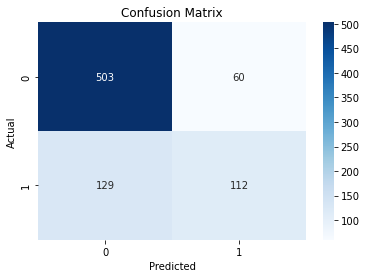

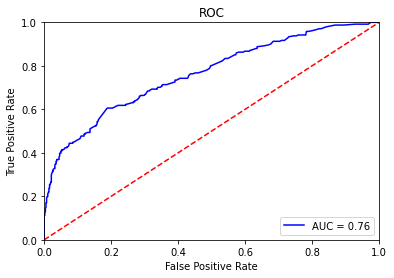

In [21]:
evaluate_model(bayes, X_train, y_train, X_test, y_test)

## Conclusion
Naive Bayes performed well, with an accuracy close to our random forest classifier.

# Combining models
In this section, we experiment with combining models, in an effort to achieve even higher accuracy.  We wrote a <code>ComboClassifier()</code> class, which accepts a list of classifiers and combines them one of two ways:
- Select the target class from the model that gives the highest probability (from <code>predict_proba()</code>)
- Select the target class by taking a majority vote among the 3 models.
Of these two approaches, selecting the class based on probability gave the best results and is used below.

In [22]:
class ComboClassifier():
    def __init__(self, models):
        self.models = models
        self._estimator_type = 'classifier'
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes_ = np.array(y.unique())
        self.fitted_models = []
        for m in self.models:
            self.fitted_models.append(m.fit(X, y))
        return self
    def get_best_proba(self, X):
        # Get best based on predict_proba() for each model
        predictions = []
        for m in self.fitted_models:
            predictions.append(list(zip(m.predict(X), m.predict_proba(X))))
        best = [(0, [0,0])]*len(X)
        for m in predictions:
            for i in range(len(X)):
                if max(m[i][1]) > max(best[i][1]):
                    best[i] = m[i]
        return best
    def get_best_vote(self, X):
        # Get best based on majority of models
        # This will only work if we have an odd number of models.
        predictions = []
        for m in self.fitted_models:
            predictions.append(list(zip(m.predict(X), m.predict_proba(X))))
        best = [(0, [0,0])]*len(X)
        for i in range(len(X)):
            votes = []
            for m in predictions:
                votes.append((m[i][0], m[i][1]))
            winner = mode([v[0] for v in votes])
            winner_prob = max(list(itertools.chain(*[v[1] for v in votes if v[0] == winner])))
            best[i] = ((winner, [winner_prob,1-winner_prob]))
        return best
    def predict(self, X):
        return [i[0] for i in self.get_best_proba(X)]
    def predict_proba(self, X):
        return np.array([i[1] for i in self.get_best_proba(X)])

combo = ComboClassifier([best_forest, best_logistic, bayes])


Training data
-------------
Accuracy: 0.8186721991701245
Precision: 0.7912713472485768
Recall: 0.5604838709677419

Test data
---------
Accuracy: 0.8059701492537313
Precision: 0.7544910179640718
Recall: 0.5228215767634855

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       563
           1       0.75      0.52      0.62       241

    accuracy                           0.81       804
   macro avg       0.79      0.72      0.74       804
weighted avg       0.80      0.81      0.79       804



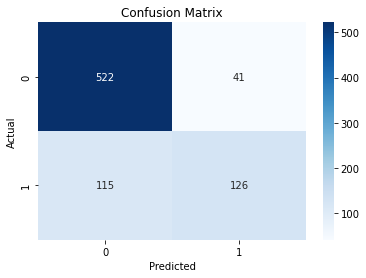

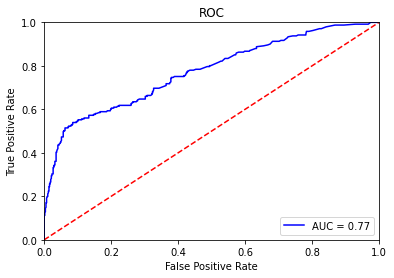

In [23]:
evaluate_model(combo, X_train, y_train, X_test, y_test)

In [24]:
forest_diff = sum(1 for i, j in zip(combo.predict(X_test), best_forest.predict(X_test)) if i != j)
logistic_diff = sum(1 for i, j in zip(combo.predict(X_test), best_logistic.predict(X_test)) if i != j)
bayes_diff = sum(1 for i, j in zip(combo.predict(X_test), bayes.predict(X_test)) if i != j)
print('Combo model differs from random forest by {} points.'.format(forest_diff))
print('Combo model differs from logistic regression {} points.'.format(logistic_diff))
print('Combo model differs from naive bayes by {} points.'.format(bayes_diff))

Combo model differs from random forest by 66 points.
Combo model differs from logistic regression 135 points.
Combo model differs from naive bayes by 77 points.


## Conclusion

Combining our random forest, logistic regression, and naive Bayes classifiers and predicting the target based on the probability predictions of the underlying models produced a slight increase in accuracy, to __81%__.

## Sanity check:  Dummy classifier


Training data
-------------
Accuracy: 0.5738589211618257
Precision: 0.3069577080491132
Recall: 0.3024193548387097

Test data
---------
Accuracy: 0.5771144278606966
Precision: 0.30278884462151395
Recall: 0.3153526970954357

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       563
           1       0.30      0.32      0.31       241

    accuracy                           0.58       804
   macro avg       0.50      0.50      0.50       804
weighted avg       0.58      0.58      0.58       804



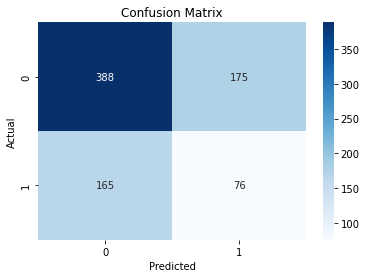

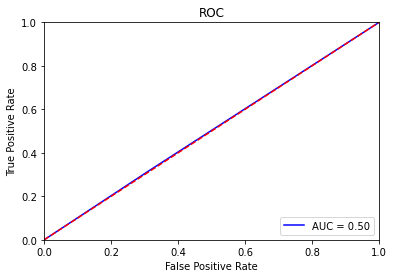

In [25]:
dummy = DummyClassifier(strategy='stratified', random_state=random_state)
dummy.fit(X_train, y_train)
evaluate_model(dummy, X_train, y_train, X_test, y_test)

## Conclusion
The Dummy classifier is useful as a simple baseline to compare with other (real) classifiers. By selecting the stratified strategy, the classifier generated predictions based on the training set's class distribution, and its ROC curve is that of a random classifier.

# Conclusion

In this project, we developed a machine learning model to predict a calling plan choice based on subscriber usage data for Megaline.  We built models using random forest, logistic regression, and naive Bayes classifiers.  Then, using these underlying models, we developed a combined model, which achieved a prediction accuracy of __81%__ on the test dataset.

# Resources
- __Model evaluation__
    - _The ultimate guide to binary classification metrics_: https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a
    - _Receiver operating characteristic_: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
    - _Confusion matrix_: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    - _Understanding the Classification report through sklearn_: https://muthu.co/understanding-the-classification-report-in-sklearn/
    - _Classification: Precision and Recall_: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
    - _Classification: Accuracy_: https://developers.google.com/machine-learning/crash-course/classification/accuracy
- __Grid search__
    - _Optimize Hyperparameters with GridSearch_: https://medium.com/analytics-vidhya/optimize-hyperparameters-with-gridsearch-d351b0fd339d
    - _Using explicit (predefined) validation set for grid search with sklearn_: https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn

    - _How to Improve Class Imbalance using Class Weights in Machine Learning_; https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
    - _Cross-validation: evaluating estimator performance_: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
- __Random forest__
    - _What’s in a “Random Forest”? Predicting Diabetes_: https://towardsdatascience.com/whats-in-a-random-forest-predicting-diabetes-18f3707b6343
    - _Open Machine Learning Course. Topic 5. Bagging and Random Forest_: https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7
    - _Growing a Random Forest using Sklearn’s DecisionTreeClassifier_: https://towardsdatascience.com/growing-a-random-forest-using-sklearns-decisiontreeclassifier-24e048e8bd84
    - _Advantages and Disadvantages of Random Forest Algorithm in Machine Learning_: https://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of-random.html
- __Logistic regression__
    - _Why use Logistic Regression?_: https://medium.com/analytics-vidhya/why-use-logistic-regression-6cd17e09e6d0
    - _Logistic Regression Model Tuning with scikit-learn — Part 1_: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
    - _How to Improve Logistic Regression?_: https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492
    - _Advantages and Disadvantages of Logistic Regression_: https://iq.opengenus.org/advantages-and-disadvantages-of-logistic-regression/
    - _Common pitfalls in statistical analysis: Logistic regression_: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/
    - 
- __Naive Bayes__
    - _Naive Bayes Overview_: https://medium.com/@heylemaster/naive-bayes-overview-1fee34268f6d
    - _Naive Bayes Explained_: https://towardsdatascience.com/naive-bayes-explained-9d2b96f4a9c0